In [1]:
"""
Training a neural operator on Darcy-Flow
========================================
In this example, we demonstrate how to use the small Darcy-Flow example we ship with the package
"""

# %%
# 


import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss

device = 'cpu'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [2]:

# %%
# Loading the Navier-Stokes dataset in 128x128 resolution
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)


# %%
# We create a tensorized FNO model

model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32

Our model has 389697 parameters.


In [11]:
#train_dataset = train_loader.dataset
## Which sample to view
#index = 0
#
#data = train_dataset[index]
#x = data['x']
#y = data['y']
#
#print(x)

tensor([[[1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000

In [3]:

# %%
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


# %%
# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}


# %%


print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


# %% 
# Create the trainer
trainer = Trainer(model, n_epochs=20,
                  device=device,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)


# %%
# Actually train the model on our small Darcy-Flow dataset

trainer.train(train_loader, test_loaders,
              output_encoder,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)




### MODEL ###
 TFNO(
  (convs): FactorizedSpectralConv(
    (weight): ModuleList(
      (0): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      (1): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      (2): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      (3): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      (4): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      (5): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      (6): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      (7): ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
    )
  )
  (fno_skips): ModuleList(
    (0): SoftGating()
    (1): SoftGating()
    (2): SoftGating()
    (3): SoftGating()
  )
  (lifting): Lifting(
    (fc): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (projection): Projection(
    (fc1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (fc2): Conv2d(64, 

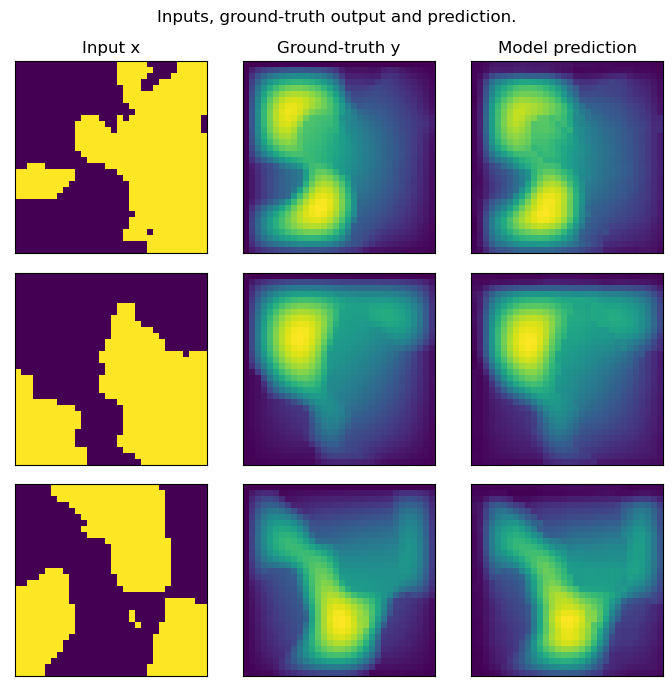

In [9]:

# %%
# Plot the prediction, and compare with the ground-truth 
# Note that we trained on a very small resolution for
# a very small number of epochs
# In practice, we would train at larger resolution, on many more samples.
# 
# However, for practicity, we created a minimal example that
# i) fits in just a few Mb of memory
# ii) can be trained quickly on CPU
#
# In practice we would train a Neural Operator on one or multiple GPUs

test_samples = test_loaders[32].dataset
model = model.cpu()


fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    #ax.imshow(x[0], cmap='gray')
    ax.imshow(x[0])
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
#fig.show()
plt.show()

In [14]:
print(x.shape)
print(y.shape)

torch.Size([3, 16, 16])
torch.Size([1, 16, 16])
